# MNIST Digit recognition with Tensorflow
MNIST is a popular dataset with handwritten digits. I will attempt to recognize these digits by throwing a bunch of layers at it.

## Loading the data

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras import layers
from keras.layers import concatenate
from keras.models import Model, Sequential

import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

2023-09-14 08:07:03.558369: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
# usually the shape of one datapoint is like (width, height, 3) where 3 is bc RGB so that is how cnn works, but right now it is (width, height) and wee need to make it (width, height, 1) so it can tell what is one pixel
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

# so it is 2 = [0, 0, 1, 0, 0... and 4 = [0, 0, 0, 0, 1, 0, 0...
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000, 10)
(10000, 28, 28, 1)
(10000, 10)


[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


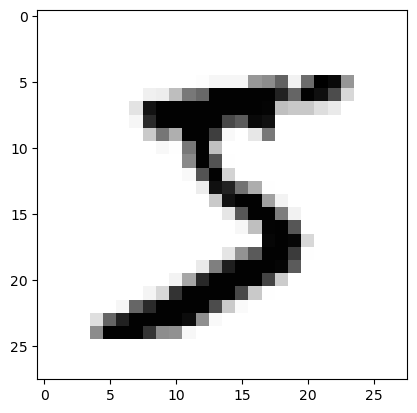

In [6]:
plt.imshow(X_train[0], cmap="Greys")
plt.plot()
print(y_train[0])

# Sequential Model

In [7]:
cnn_model = Sequential(
    [
        keras.Input(shape=X_train[0].shape),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(10, activation="softmax"),
    ]
)

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

2023-09-14 08:07:08.083701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
keras.utils.model_to_dot(cnn_model).write_png("cnn_model.png")

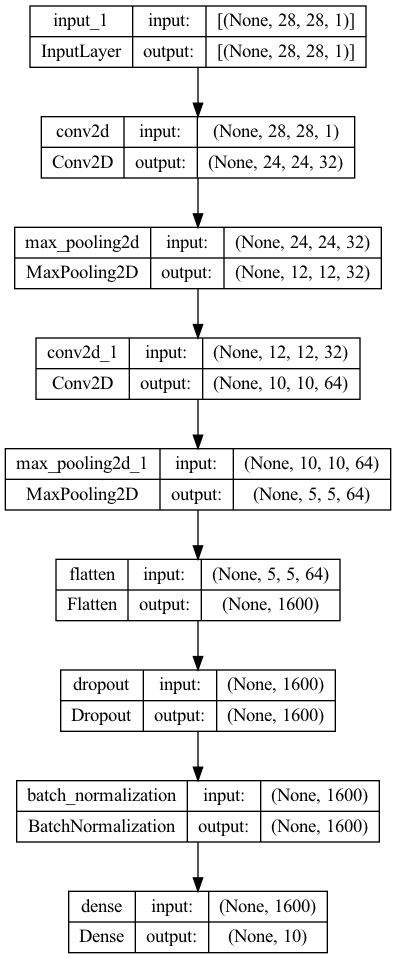

In [9]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [10]:
cnn_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
cnn_model.fit(X_train, y_train, epochs=3, validation_split=0.1, batch_size=50)

Epoch 1/3
 389/1080 [=========>....................] - ETA: 7s - loss: 0.2607 - accuracy: 0.9208

KeyboardInterrupt: 

In [11]:
def plot_confusion_matrix(model: Model, X_test = X_test, y_test = y_test, digits = 5):
    y_pred = model.predict(X_test)

    # np argmax turns [0, 0, 1, 0, 0, ... into 2 and so on
    # aka undoes one hot encoding
    y_test = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    print(classification_report(y_test, y_pred, digits=digits))

In [12]:
def show_random_incorrect_guess(model: Model, X_test = X_test, y_test = y_test):
    y_pred = model.predict(X_test)

    y_test = np.argmax(y_test, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    incorrect_guess_indices = []
    for i in range(X_test.shape[0]):
        if (y_test[i]!=y_pred[i]): incorrect_guess_indices.append(i)
    
    import random

    random_index = random.choice(incorrect_guess_indices)

    plt.imshow(X_test[random_index], cmap="Greys")
    print("Index:", random_index)
    print("True:", y_test[random_index])
    print("Pred:", y_pred[random_index])

313/313 [==============================] - 1s 3ms/step


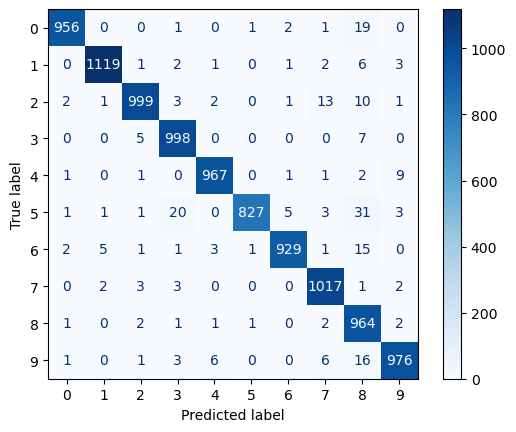

In [ ]:
plot_confusion_matrix(cnn_model)

313/313 [==============================] - 1s 4ms/step
Index: 9216
True: 9
Pred: 8


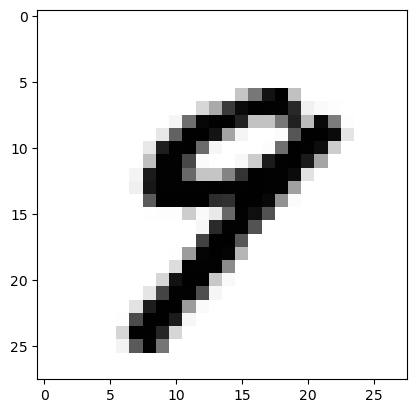

In [ ]:
show_random_incorrect_guess(cnn_model)

# Branching CNN
I saw an article about a branching cnn so lets try that

Source: https://bura.brunel.ac.uk/bitstream/2438/20200/4/Preprint.pdf

In [13]:
def create_branching_cnn():
    input_layer = keras.Input(X_train[0].shape)

    conv123 = Sequential([
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        # layers.MaxPooling2D(pool_size=(2, 2)),
    ])(input_layer)

    conv456 = Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        # layers.MaxPooling2D(pool_size=(2, 2)),
    ])
    
    conv456=conv456(conv123)

    conv789 = Sequential([
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu"),
        # layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(8, kernel_size=(3, 3), activation="relu"),
        # layers.MaxPooling2D(pool_size=(2, 2)),
    ])(conv456)

    # idk what capsules are so i'll just use dense
    dense1 = Sequential([
        layers.Flatten(),
        layers.Dropout(0.1),
        layers.BatchNormalization(),
        layers.Dense(8, activation="softmax"),
        layers.Dense(16, activation="softmax"),
        layers.Dense(32, activation="softmax"),
    ])(conv123)

    dense2 = Sequential([
        layers.Flatten(),
        layers.Dropout(0.1),
        layers.BatchNormalization(),
        layers.Dense(32, activation="softmax"),
        layers.Dense(32, activation="softmax"),
    ])(conv456)

    dense3 = Sequential([
        layers.Flatten(),
        layers.Dropout(0.1),
        layers.BatchNormalization(),
        layers.Dense(64, activation="softmax"),
        layers.Dense(32, activation="softmax"),
    ])(conv789)
 
    merged_output = layers.Concatenate()([dense1, dense2, dense3])

    combined_model = layers.Dense(10, activation="softmax")(merged_output)
    combined_model = Model(inputs=input_layer, outputs=combined_model)

    combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return combined_model

In [14]:
branching_cnn = create_branching_cnn()

In [15]:
keras.utils.model_to_dot(branching_cnn, show_shapes=True, expand_nested=True).write_png("branching_cnn.png")

In [16]:
branching_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 22, 22, 32)   56032       ['input_2[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 16, 16, 16)   23120       ['sequential_1[0][0]']           
                                                                                                  
 sequential_3 (Sequential)      (None, 10, 10, 8)    5800        ['sequential_2[0][0]']           
                                                                                              

In [17]:
branching_cnn.fit(x=X_train, y=y_train)

  36/1875 [..............................] - ETA: 2:14 - loss: 2.2953 - accuracy: 0.1050

KeyboardInterrupt: 

In [ ]:
branching_cnn.fit(x=X_train, y=y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 1083s 578ms/step - loss: 0.1797 - accuracy: 0.9594
Epoch 2/10
1875/1875 [==============================] - 135s 72ms/step - loss: 0.1492 - accuracy: 0.9626
Epoch 3/10
1875/1875 [==============================] - 134s 72ms/step - loss: 0.1337 - accuracy: 0.9652
Epoch 4/10
1875/1875 [==============================] - 132s 70ms/step - loss: 0.1261 - accuracy: 0.9674
Epoch 5/10
1875/1875 [==============================] - 134s 72ms/step - loss: 0.1253 - accuracy: 0.9684
Epoch 6/10
1875/1875 [==============================] - 136s 73ms/step - loss: 0.1141 - accuracy: 0.9702
Epoch 7/10
1875/1875 [==============================] - 134s 72ms/step - loss: 0.1138 - accuracy: 0.9699
Epoch 8/10
1875/1875 [==============================] - 5745s 3s/step - loss: 0.1040 - accuracy: 0.9727
Epoch 9/10
1875/1875 [==============================] - 134s 71ms/step - loss: 0.1001 - accuracy: 0.9734
Epoch 10/10
1875/1875 [==============================]

Like I thought I overcomplicated this.
I am going to look for the smallest model that does more than 99%.

# Small models

Trying to minimize # parameters

In [18]:
def create_simple_model():
    simple_model = Sequential([
            keras.Input(shape=X_train[0].shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.BatchNormalization(),
            layers.Dense(10, activation="softmax"),
    ])

    simple_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return simple_model

In [19]:
simple_model = create_simple_model()

In [20]:
simple_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 800)               0         
                                                                 
 dropout_4 (Dropout)         (None, 800)              

In [21]:
simple_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.1781 - accuracy: 0.9450
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0783 - accuracy: 0.9755
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0633 - accuracy: 0.9802
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0617 - accuracy: 0.9796
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0560 - accuracy: 0.9836
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0520 - accuracy: 0.9840
Epoch 7/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0526 - accuracy: 0.9839
Epoch 8/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0495 - accuracy: 0.9844
Epoch 9/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0462 - accuracy: 0.9858
Epoch 10/10
1875/1875 [==============================] - 13s 7ms/step - l

313/313 [==============================] - 1s 2ms/step


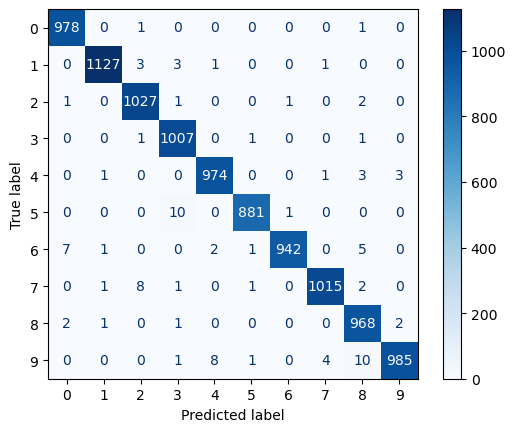

              precision    recall  f1-score   support

           0    0.98988   0.99796   0.99390       980
           1    0.99646   0.99295   0.99470      1135
           2    0.98750   0.99516   0.99131      1032
           3    0.98340   0.99703   0.99017      1010
           4    0.98883   0.99185   0.99034       982
           5    0.99548   0.98767   0.99156       892
           6    0.99788   0.98330   0.99054       958
           7    0.99412   0.98735   0.99073      1028
           8    0.97581   0.99384   0.98474       974
           9    0.99495   0.97621   0.98549      1009

    accuracy                        0.99040     10000
   macro avg    0.99043   0.99033   0.99035     10000
weighted avg    0.99047   0.99040   0.99040     10000



In [22]:
plot_confusion_matrix(simple_model)

It might get to 99 if I train it enough, but I am going to try to change some stuff.

In [23]:
def create_simple_model_v2():
    simple_model = Sequential([
            keras.Input(shape=X_train[0].shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(10, activation="softmax"),
    ])

    simple_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return simple_model

In [24]:
simple_model_2 = create_simple_model_v2()

In [25]:
simple_model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 800)               0         
                                                                 
 dense_10 (Dense)            (None, 10)               

In [26]:
simple_model_2.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.3844 - accuracy: 0.9328
Epoch 2/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0782 - accuracy: 0.9768
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0620 - accuracy: 0.9811
Epoch 4/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0536 - accuracy: 0.9833
Epoch 5/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0474 - accuracy: 0.9855
Epoch 6/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0424 - accuracy: 0.9866
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0383 - accuracy: 0.9884
Epoch 8/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0347 - accuracy: 0.9895
Epoch 9/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0343 - accuracy: 0.9894
Epoch 10/10
1875/1875 [==============================] - 12s 6ms/step - l

313/313 [==============================] - 1s 2ms/step


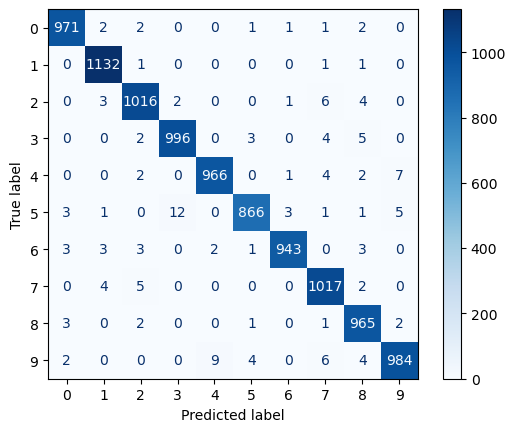

              precision    recall  f1-score   support

           0    0.98880   0.99082   0.98981       980
           1    0.98865   0.99736   0.99298      1135
           2    0.98354   0.98450   0.98402      1032
           3    0.98614   0.98614   0.98614      1010
           4    0.98874   0.98371   0.98622       982
           5    0.98858   0.97085   0.97964       892
           6    0.99368   0.98434   0.98899       958
           7    0.97695   0.98930   0.98308      1028
           8    0.97573   0.99076   0.98319       974
           9    0.98597   0.97522   0.98057      1009

    accuracy                        0.98560     10000
   macro avg    0.98568   0.98530   0.98546     10000
weighted avg    0.98564   0.98560   0.98559     10000



In [27]:
plot_confusion_matrix(simple_model_2)

It might have been luck but the dropout actually decreased training accuracy.
Dropout is a way to reduce overfitting, so this is why dropout is less useful in smaller models.

It actually did lead to a slightly better testing result, so it did do its job in the long run.

However, with my next technique, pruning, it should be able to make the model smaller and reduce overfitting.

In [28]:
simple_model_2_with_pruning = create_simple_model_v2()

In [29]:
simple_model_2_with_pruning.summary() # right now, should be same as the other one

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 800)               0         
                                                                 
 dense_11 (Dense)            (None, 10)               

In [30]:
! pip3 install tensorflow-model-optimization

In [31]:
import tempfile
import tensorflow_model_optimization as tfmot

In [32]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

# not changing any other training hyperparameters to not affect testing
simple_model_2_with_pruning.fit(X_train, y_train, epochs=10, callbacks=callbacks)

Epoch 1/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4172 - accuracy: 0.9305
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0812 - accuracy: 0.9761
Epoch 3/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0653 - accuracy: 0.9805
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0565 - accuracy: 0.9823
Epoch 5/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0461 - accuracy: 0.9858
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0450 - accuracy: 0.9863
Epoch 7/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0409 - accuracy: 0.9873
Epoch 8/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0357 - accuracy: 0.9893
Epoch 9/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0347 - accuracy: 0.9892
Epoch 10/10
1875/1875 [==============================] - 12s 6ms/step - l

In [33]:
simple_model_2_with_pruning.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 800)               0         
                                                                 
 dense_11 (Dense)            (None, 10)               

313/313 [==============================] - 1s 3ms/step


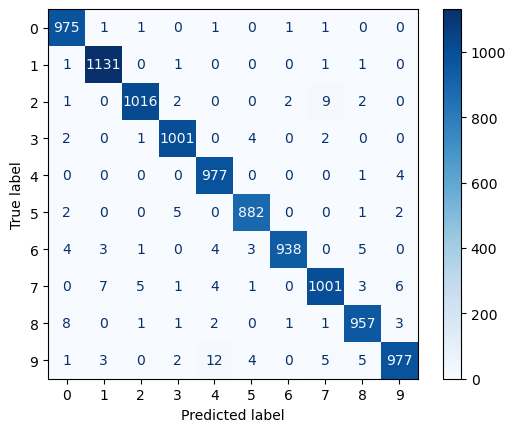

              precision    recall  f1-score   support

           0    0.98089   0.99490   0.98784       980
           1    0.98777   0.99648   0.99211      1135
           2    0.99122   0.98450   0.98785      1032
           3    0.98815   0.99109   0.98962      1010
           4    0.97700   0.99491   0.98587       982
           5    0.98658   0.98879   0.98768       892
           6    0.99575   0.97912   0.98737       958
           7    0.98137   0.97374   0.97754      1028
           8    0.98154   0.98255   0.98204       974
           9    0.98488   0.96829   0.97651      1009

    accuracy                        0.98550     10000
   macro avg    0.98552   0.98543   0.98544     10000
weighted avg    0.98553   0.98550   0.98549     10000



In [34]:
plot_confusion_matrix(simple_model_2_with_pruning)

Pruning doesn't explicitly remove parameters, just makes them permenantly 0.

In [43]:
def create_simple_model_3():
    simple_model_3 = Sequential([
            keras.Input(shape=X_train[0].shape),
            layers.Conv2D(20, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(20, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.BatchNormalization(),
            layers.Dense(10, activation="softmax"),
    ])

    simple_model_3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return simple_model_3

In [44]:
simple_model_3 = create_simple_model_3()

In [45]:
simple_model_3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 26, 26, 20)        200       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 11, 11, 20)        3620      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 20)         0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 500)               0         
                                                                 
 dropout_7 (Dropout)         (None, 500)             

In [46]:
simple_model_3.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2315 - accuracy: 0.9291
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0897 - accuracy: 0.9717
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0739 - accuracy: 0.9770
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0685 - accuracy: 0.9785
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0643 - accuracy: 0.9805
Epoch 6/10
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0619 - accuracy: 0.9798
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0591 - accuracy: 0.9815
Epoch 8/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0531 - accuracy: 0.9829
Epoch 9/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0521 - accuracy: 0.9836
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - l

313/313 [==============================] - 1s 2ms/step


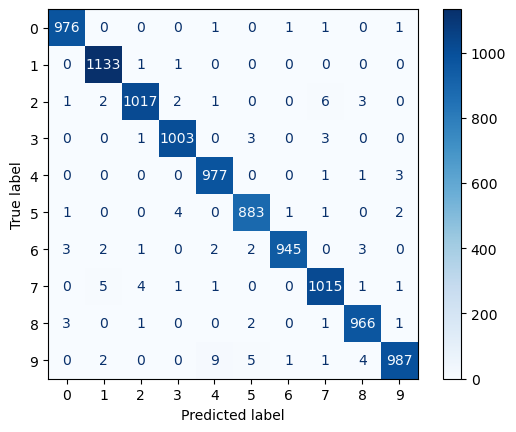

              precision    recall  f1-score   support

           0    0.99187   0.99592   0.99389       980
           1    0.99038   0.99824   0.99430      1135
           2    0.99220   0.98547   0.98882      1032
           3    0.99209   0.99307   0.99258      1010
           4    0.98587   0.99491   0.99037       982
           5    0.98659   0.98991   0.98825       892
           6    0.99684   0.98643   0.99161       958
           7    0.98639   0.98735   0.98687      1028
           8    0.98773   0.99179   0.98975       974
           9    0.99196   0.97820   0.98503      1009

    accuracy                        0.99020     10000
   macro avg    0.99019   0.99013   0.99015     10000
weighted avg    0.99022   0.99020   0.99019     10000



In [47]:
plot_confusion_matrix(simple_model_3)

This is good, but I feel I might be doing something wrong because the accuracy for test set is higher than train set. I don't know if this should ever happen.

Well, lets see how far we can push it.

In [51]:
def create_simple_model_4():
    simple_model_4 = Sequential([
            keras.Input(shape=X_train[0].shape),
            layers.Conv2D(20, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(10, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(4, 4)),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.BatchNormalization(),
            layers.Dense(10, activation="softmax"),
    ])

    simple_model_4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return simple_model_4

In [52]:
simple_model_4 = create_simple_model_4()

In [53]:
simple_model_4.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 26, 26, 20)        200       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 13, 13, 20)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 11, 11, 10)        1810      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 2, 2, 10)         0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 40)                0         
                                                                 
 dropout_9 (Dropout)         (None, 40)              

In [54]:
simple_model_4.fit(X_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.6779 - accuracy: 0.7867
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.3369 - accuracy: 0.8936
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2925 - accuracy: 0.9081
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2643 - accuracy: 0.9161
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2518 - accuracy: 0.9201
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2454 - accuracy: 0.9226
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2374 - accuracy: 0.9246
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2289 - accuracy: 0.9280
Epoch 9/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2245 - accuracy: 0.9291
Epoch 10/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0

313/313 [==============================] - 1s 2ms/step


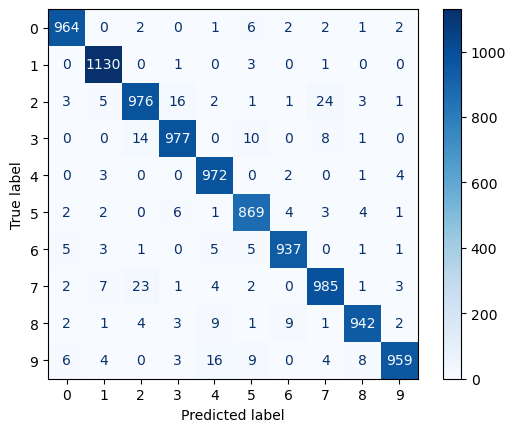

              precision    recall  f1-score   support

           0    0.97967   0.98367   0.98167       980
           1    0.97835   0.99559   0.98690      1135
           2    0.95686   0.94574   0.95127      1032
           3    0.97021   0.96733   0.96877      1010
           4    0.96238   0.98982   0.97590       982
           5    0.95916   0.97422   0.96663       892
           6    0.98115   0.97808   0.97961       958
           7    0.95817   0.95817   0.95817      1028
           8    0.97921   0.96715   0.97314       974
           9    0.98561   0.95045   0.96771      1009

    accuracy                        0.97110     10000
   macro avg    0.97108   0.97102   0.97098     10000
weighted avg    0.97117   0.97110   0.97106     10000



In [55]:
plot_confusion_matrix(simple_model_4)

Ok, so that was too simple. But, I am confused why the train accuracy was 0.92, and the test is 0.97, which is a significant INCREASE. Maybe the accuracies are implemented with different metrics and that is why the second accuracy seems too good compared to the first one. I don't know though.

I'm going to save some of the simpler ones (usually it would be more useful to save the bigger ones, but they provided very little improvement with a lot more parameters. Also, I restarted my notebook and I kind of don't want to train them again).

In [57]:
simple_model_2.save("../models/simple_model_2.keras")
simple_model_2_with_pruning.save("../models/simple_model_2_with_pruning.keras")
simple_model_3.save("../models/simple_model_3.keras")
simple_model_4.save("../models/simple_model_4.keras")